In [126]:
import sys
import os
#sys.path.insert(0, "/usr/src/app/app")
def import_path(fullpath):
    """ 
    Import a file with full path specification. Allows one to
    import from anywhere, something __import__ does not do. 
    """
    path, filename = os.path.split(fullpath)
    filename, ext = os.path.splitext(filename)
    sys.path.append(path)
    module = __import__(filename)
   # reload(module) # Might be out of date
    del sys.path[-1]
    return module
import_path("/usr/src/app/app")

<module 'app' from '/usr/src/app/app/__init__.py'>

In [127]:
from app.pkg.ml.try_on.preprocessing.aggregator import ClothProcessor
cp = ClothProcessor()

In [128]:
from app.pkg.ml.buffer_converters import BytesConverter
from PIL import Image
from app.pkg.models.app.image_category import ImageCategory
bc = BytesConverter()
outerwear_clothes_paths = ["/usr/src/app/data/upper/b_bloose.png", "/usr/src/app/data/upper/b_jacket.png"]
upper_clothes_paths = [ "/usr/src/app/data/upper/t-shirt-blue.png","/usr/src/app/data/upper/t-shirt-miami.png", "/usr/src/app/data/upper/b_t-shirt-2.png", "/usr/src/app/data/upper/b_t-shirt-3.png", "/usr/src/app/data/upper/t-shirt-dc.png", "/usr/src/app/data/upper/t-shirt-dc2.png", "/usr/src/app/data/upper/t-shirt.png" ]
lower_clothes_paths = ["/usr/src/app/data/lower/b_black_jeans.png", "/usr/src/app/data/lower/b_shorts.png", "/usr/src/app/data/lower/jeans-dc.png", "/usr/src/app/data/lower/shorts-dc.png" ]
dress_clothes_paths = ["/usr/src/app/data/dresses/1.png", "/usr/src/app/data/dresses/2.png", "/usr/src/app/data/dresses/dress-dc.png"]

user_images = ["/usr/src/app/data/human/brayan_krenston.png"]

def convert_cloth_to_dict(x, category=None):
    res = []
    for i in x:
        image = Image.open(i)
        im_no_back = cp.model_background(image)
        im_bytes = bc.image_to_bytes(im_no_back)
        res.append({'cloth':im_bytes, 'category':category})
    return res

def convert_user_to_dict(x):
    res = []
    for i in x:
        image = Image.open(i)
        im_no_back = cp.model_background(image)
        im_bytes = bc.image_to_bytes(im_no_back)
        res.append({'image':im_bytes})
    return res

#        im_white_back = cp.model_background.replace_background_RGBA(im_no_back)


upper_clothes = convert_cloth_to_dict(upper_clothes_paths, ImageCategory.UPPER_BODY)
lower_clothes = convert_cloth_to_dict(lower_clothes_paths, ImageCategory.LOWER_BODY)
dress_clothes = convert_cloth_to_dict(dress_clothes_paths, ImageCategory.DRESSES)
outerwear_clothes = convert_cloth_to_dict(outerwear_clothes_paths, ImageCategory.UPPER_BODY)
user_images = convert_user_to_dict(user_images)


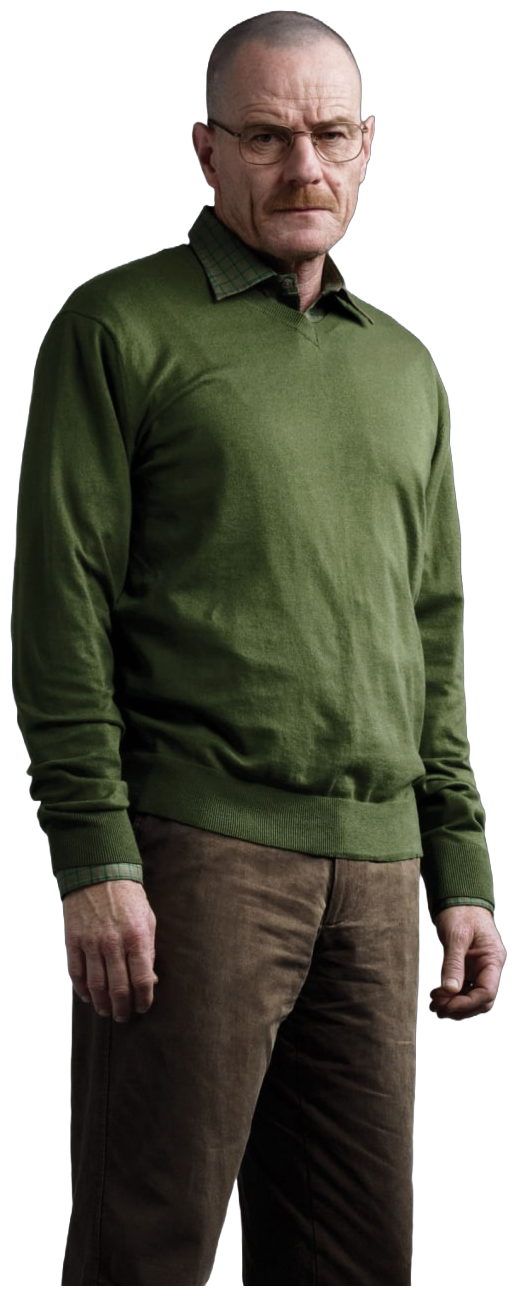

In [129]:
bc.bytes_to_image(user_images[0]['image'])

In [130]:
from typing import Dict, Union, List
import io

import torch
from transformers import AutoProcessor, CLIPModel, AutoTokenizer
from torch.nn import Softmax
from PIL import Image
import numpy as np

from app.pkg.ml.buffer_converters import BytesConverter
from app.pkg.ml.try_on.preprocessing.cloth import ClothPreprocessor

In [367]:
def sum_normalize(array):
    if isinstance(array, list):
        array = np.array(array)
    return array/array.sum()
# a = [0.1, 0.4, 0.4]
# sum_normalize(a)

1.0

In [198]:
class LocalRecSys:
    """
    Recommends set of clothes (outfit)
    """
    def __init__(self, device="cuda:0"):
        self.model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
        self.processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")
        self.tokenizer =  AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")
        self.softmax = torch.nn.Softmax(dim=0)
        

        self.device = device
        self.bytes_converter = BytesConverter()

    def forward(self,
                upper_clothes: List[Dict[str, io.BytesIO]] = [],
                lower_clothes: List[Dict[str, io.BytesIO]] = [],
                dresses_clothes: List[Dict[str, io.BytesIO]] = [],
                outerwear_clothes: List[Dict[str, io.BytesIO]] = [],
                
                # user_photos:List[Dict[str, io.BytesIO]],
                prompt: str = None,
                sample_amount: int = 10,
               ) -> Dict[str, Dict[str, float]]:
        """
        Gets probability for each tag
        
        Args:
            upper_clothes: List[Dict[str, io.BytesIO]],
            lower_clothes: List[Dict[str, io.BytesIO]],
            dresses_clothes: List[Dict[str, io.BytesIO]],
            prompt: str = None - extra prompt to search
            sample_amount: int = 10 - samples of outfits  
        Returns:
            dict with sets of clothes
        
        Return example:
        [
            {
            "score":1,
            "clothes":[,]
            },
            {
            "score":0.93,
            "clothes":[,]
            },
        ]
        """

        upper_clothes = self.get_embs_per_category(upper_clothes)
        lower_clothes = self.get_embs_per_category(lower_clothes)
        dresses_clothes = self.get_embs_per_category(dresses_clothes)
        outerwear_clothes = self.get_embs_per_category(outerwear_clothes)


        if prompt:
            prompt_features = self._get_text_embedding(prompt)
        else:
            prompt_features = None

        # перебор все возможных комбинаций одежды
        outfits = []
        for up_cloth in upper_clothes:
            for low_cloth in lower_clothes:
                for outer_wear_cloth in [*outerwear_clothes, None]:
                    outfit = {'clothes':[up_cloth, low_cloth]}
                    if outer_wear_cloth is not None:
                      outfit['clothes'].append(outer_wear_cloth)  
                    self._evaluate_outfit(outfit=outfit,
                        prompt_features=prompt_features)
                    outfits.append(outfit)
                
        for dress in dresses_clothes:
         
                outfit = {'clothes':[dress]}
                self._evaluate_outfit(outfit=outfit,
                    prompt_features=prompt_features)

                outfits.append(outfit)

        for cloth in [*upper_clothes, *lower_clothes, *dresses_clothes, *outerwear_clothes]:
            del cloth['tensor']

        sorted_outfits = sorted(outfits, key=lambda x: x['score'], reverse=True)
        return self.sample_outfit(sorted_outfits, sample_amount)

    def _evaluate_outfit(self, outfit, prompt_features):
        score_list = [cloth['tensor'] for cloth in outfit['clothes']]

        if prompt_features is not None:
            prompt_correlations = [(prompt_features@score).item() for score in score_list]
        else:
            prompt_correlations=[0]

        if len(outfit['clothes']) > 1:
            clothes_score = self.dot_product(*score_list).item()/len(outfit['clothes'])
        else:
            clothes_score = 0

        outfit['score'] = 25 * np.mean(prompt_correlations) + clothes_score
        outfit['clothes_score'] = clothes_score
        outfit['prompt_corr'] = np.mean(prompt_correlations)
        
    def get_embs_per_category(self, clothes:List[Dict[str, io.BytesIO]]):
        clothes = self.prepare_clothes(clothes)
        pil_clothes = [cloth['cloth'] for cloth in clothes]
        image_features = self._get_images_embedding(pil_clothes)
        for cloth, tensor in zip(clothes, image_features):
            cloth['tensor'] = tensor
        return clothes


    def prepare_clothes(self, clothes: list):
        new_clothes = []      
        for cloth in clothes:
            new_cloth = {}
            cloth_no_background = self.bytes_converter.bytes_to_image(cloth['cloth'])
            white_background_cloth = ClothPreprocessor.replace_background_RGBA(
                                                        cloth_no_background,
                                                        color=(255,255,255)
                                                        )
            new_cloth['cloth'] = white_background_cloth
            new_clothes.append(new_cloth)
        return new_clothes            


    @torch.inference_mode()
    def _get_text_embedding(self, text:str ) -> torch.tensor:
        """
        Gets images embeddings
        
        Args:
            images:List[Dict[str, Image]] - images to get embeddings
            
        Returns:
            original dict but with embeddings
        """

        if len(text) == 0:
            raise ValueError("Got empty text")

        text_inputs = self.tokenizer(text, padding=True, return_tensors="pt")
        self._input_to_device(text_inputs)

        text_features = self.model.get_text_features(**text_inputs)

        return text_features


    @torch.inference_mode()
    def _get_images_embedding(self, images:List[Image.Image] ) \
                                ->List[Dict[str, Union[Image.Image, torch.tensor]]]:
        """
        Gets images embeddings
        
        Args:
            images:List[Dict[str, Image]] - images to get embeddings
            
        Returns:
            original dict but with embeddings
        """

        if len(images) == 0:
            return []

        image_inputs = self.processor(images=images, return_tensors="pt")
        self._input_to_device(image_inputs)

        image_features = self.model.get_image_features(**image_inputs)

        return image_features

    def sample_outfit(self, outfits, sample_amount):

        scores =torch.tensor([outfit['score']/30 for outfit in outfits])
        normalized_scores = self.softmax(scores)

        top_p_scores = None
        top_p_index = None
        top_p = 0.9
        for i, score in enumerate(normalized_scores):
            if normalized_scores[:i].sum() > top_p:
                top_p_scores = normalized_scores[:i]
                top_p_index = i
                break

        new_scores = sum_normalize(top_p_scores)

        indexes = np.arange(len(outfits))
        sampled_indexes = np.random.choice(indexes,(sample_amount,), p=new_scores ,replace=False)
        filtered_outfit = [outfits[i] for i in sampled_indexes]
        return filtered_outfit

    def _input_to_device(self, input_data:dict):
        """
        Converts input dict values to device
        """
        for key, value in input_data.items():
            if isinstance(value, torch.Tensor):
                input_data[key] = value.to(self.device)

    @staticmethod
    def dot_product(*args: List[torch.tensor]):

        num = 1
        for i in args:
            if i is not None:
                num *= i.flatten()
        return num.sum()


In [199]:
lrs = LocalRecSys()

In [293]:
outfits = lrs.forward(upper_clothes=upper_clothes,
            lower_clothes=lower_clothes,
            dresses_clothes=dress_clothes,
            outerwear_clothes=outerwear_clothes,
            prompt = 'clothes for gym',# 'clothes for cinema', # "clothes for theatre",#"beachwear",#"clothes for beach", #"party clothes", #
            top_n=100
            )

In [294]:
0.5* LocalRecSys.sigmoid(64)

0.49917059945991277

In [295]:
sf = torch.nn.Softmax(dim=0)

scores =torch.tensor([outfit['score']/30 for outfit in outfits])
normalized_scores = sf(scores)

top_p_scores = None
top_p_index = None
top_p = 0.9
for i, score in enumerate(normalized_scores):
    if normalized_scores[:i].sum() > top_p:
        top_p_scores = normalized_scores[:i]
        top_p_index = i
        break
top_p_scores

tensor([0.1446, 0.1385, 0.0906, 0.0704, 0.0594, 0.0541, 0.0505, 0.0454, 0.0400,
        0.0391, 0.0309, 0.0263, 0.0239, 0.0216, 0.0185, 0.0138, 0.0136, 0.0128,
        0.0122], dtype=torch.float64)

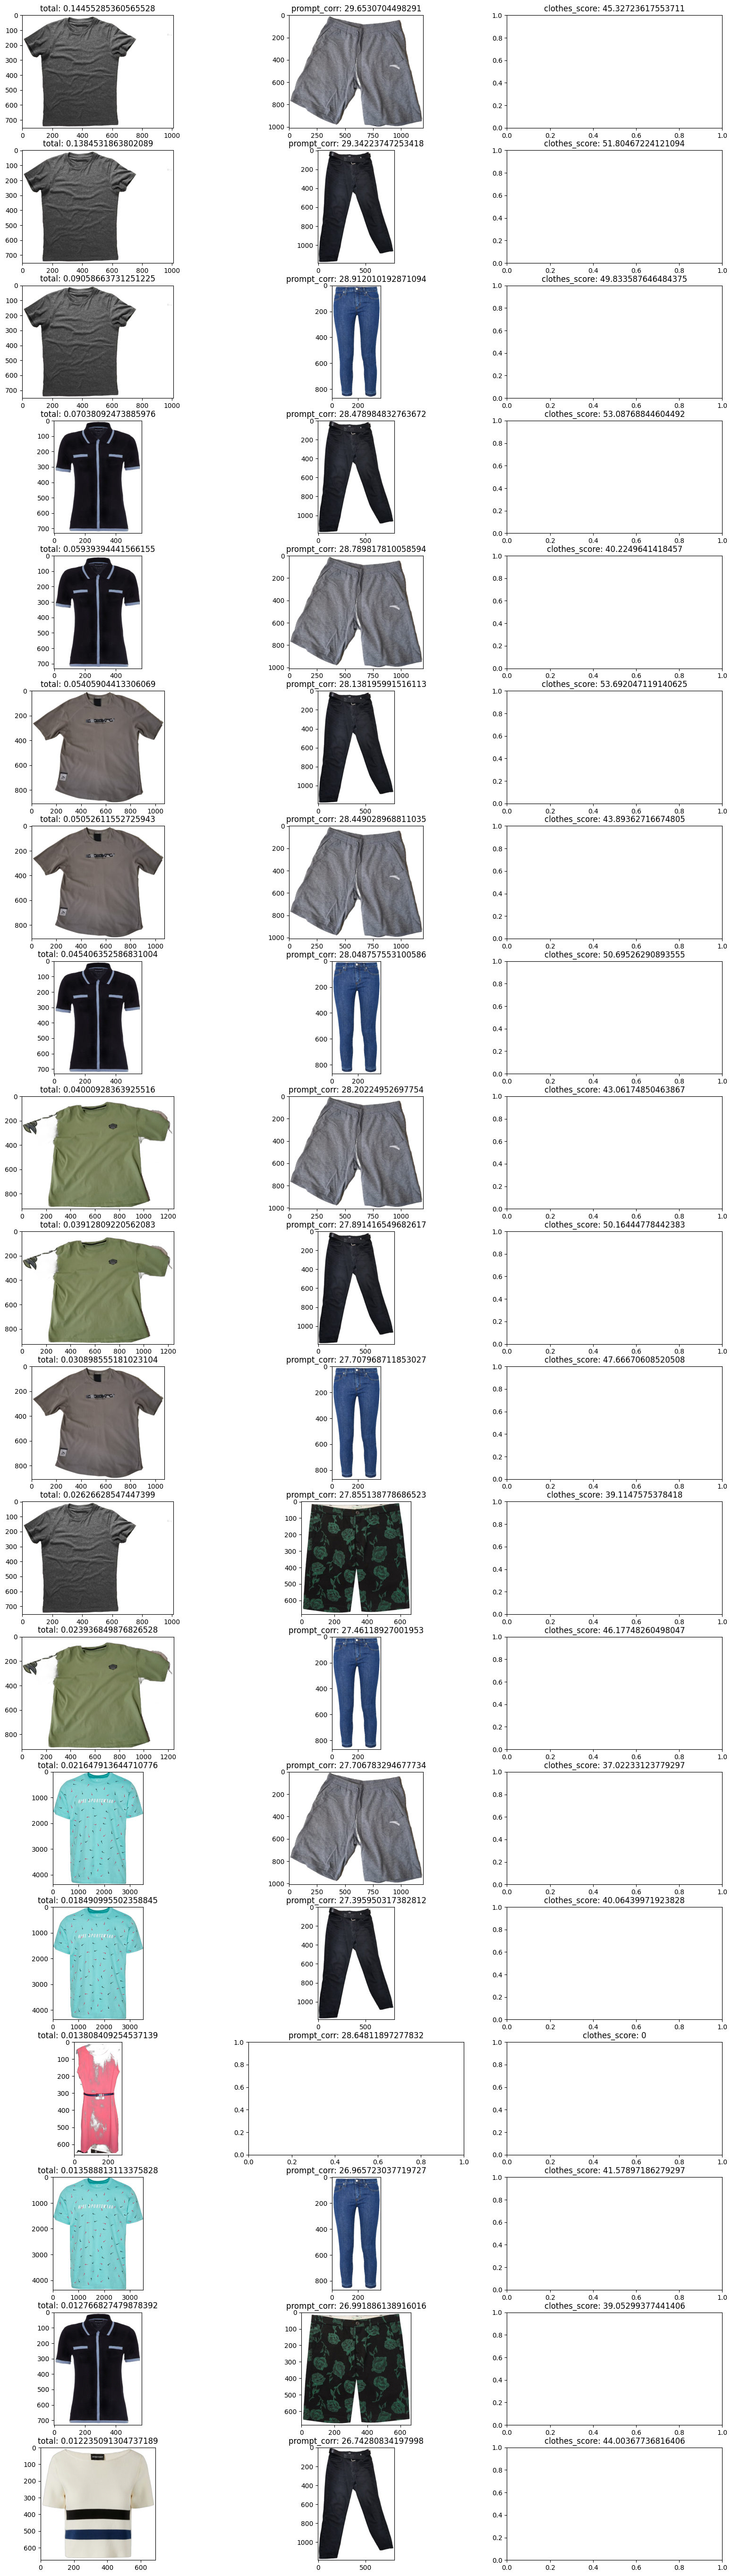

In [296]:
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (20,70)
def plot_outfits(outfits_):
    outfits = outfits_[:top_p_index]

    fig, axs = plt.subplots(len(outfits), 3)
    for i, outfit in enumerate(outfits):
        #title =  * 3
        total_score = top_p_scores[i]# outfit['score']
        axs[i,0].set_title(f'total: {total_score}')

        prompt_corr = outfit['prompt_corr']
        axs[i,1].set_title(f'prompt_corr: {prompt_corr}')

        clothes_score = outfit['clothes_score']
        axs[i,2].set_title(f'clothes_score: {clothes_score}')

                           
        for j, cloth in enumerate(outfit['clothes']):
            axs[i, j].imshow(cloth['cloth'])

#    axs[1, 1].scatter(x, y)

plot_outfits(outfits)    

array([0, 4, 2])

<Axes: xlabel='scores', ylabel='Count'>

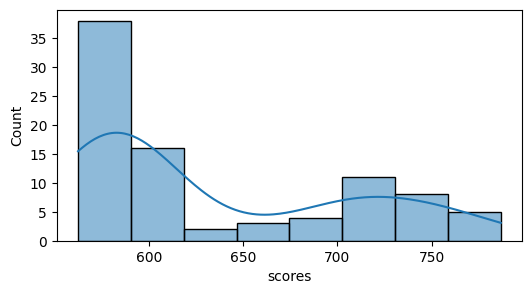

In [297]:
from matplotlib import pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (6,3)
import pandas as pd
data = pd.DataFrame({"scores":[outfit['score'] for outfit in outfits]}) # ['scores']
sns.histplot(data=data,
             x="scores",
             kde=True)


([<matplotlib.patches.Wedge at 0x768b9cd03430>,
 [Text(0.9647243562007043, 0.5284949541416046, ''),
  Text(0.09715827957844438, 1.0957008116768725, ''),
  Text(-0.7133772084498623, 0.8373129393866322, ''),
  Text(-1.048544374557765, 0.33249766101924066, ''),
  Text(-1.0887944009662522, -0.15661019259467138, ''),
  Text(-0.9456206146394553, -0.5619623236204531, ''),
  Text(-0.6848035947201693, -0.8608391467970856, ''),
  Text(-0.3662088580192748, -1.0372516918801429, ''),
  Text(-0.04756871245737705, -1.0989709812343307, ''),
  Text(0.25196729672858215, -1.0707532308516705, ''),
  Text(0.5019929193188124, -0.978776332444638, ''),
  Text(0.6848838669298979, -0.8607752835782112, ''),
  Text(0.8236028212861556, -0.7291628026507422, ''),
  Text(0.9280985232332077, -0.5904516332201473, ''),
  Text(1.0010298714936177, -0.45600350478639035, ''),
  Text(1.045717750978507, -0.34128343834480646, ''),
  Text(1.073372485857655, -0.24056497376750077, ''),
  Text(1.0908457249429946, -0.14161781093348

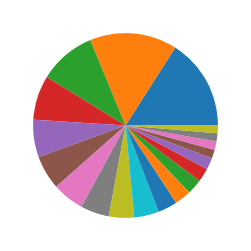

In [298]:

#data = pd.DataFrame({"scores":top_p_scores.tolist()})
plt.pie(top_p_scores.tolist(), )#, colors = colors, autopct='%.0f%%')
#data